## Bretthorst-Jaynes Analysis

In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import skewnorm, norm

mpl.rc('font', size=20)
%matplotlib inline

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [2]:
include_wls = False

In [3]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        a = np.insert(a, np.zeros(n-1,dtype=int), np.zeros(n-1), axis=-1)
        a = np.roll(a, -int((n-1)/2), axis=-1)
    if const_padding:
        l1 = int(n/2)
        if n%2 != 1: # n is even
            l2 = l1-1
        else: # n is odd
            l2 = l1
            ind2 = -np.arange(1,(n+1)/2).astype(int)
        a = np.insert(a, np.zeros(l1, dtype=int), np.ones(l1)*a[0])
        a = np.insert(a, -np.ones(l2, dtype=int), np.ones(l2)*a[-1])
    ret = np.cumsum(a, dtype=float, axis=-1)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
#Returns binning needed to resolve a frequency.
def get_binning(sim, dt, frequency=80*u.Hz): 
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    return int((1/frequency*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

In [5]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

def get_average_signal(sim, dt, distance, frequency=80*u.Hz):
    binning = get_binning(sim, dt, frequency)

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md
    t = t.to(u.ms)

    #averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)
    
    return sa_gen2, sa_ic86

In [6]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun,
             'direction': 1}
        }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()

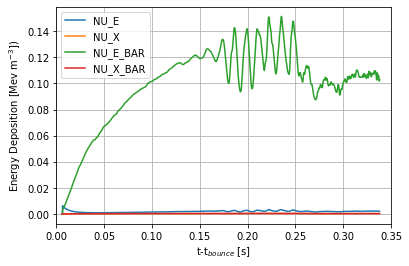

In [7]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0, 0.35))
ax.grid()

In [8]:
#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

In [9]:
def signal_processing(sim, dt, distance, trials, dist = skewnorm, sig_method='pdf_median', 
                      residual=True, smoothing=False,
                      return_raw=False,
                      return_percentage=False,
                      return_fourier=False, 
                      return_power=False, 
                      return_bretthorst_jaynes = False,
                      return_pfbj=False,
                      return_max_power=False,
                      return_test_statistics=False,
                      return_significance=False):

    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    sa_gen2, sa_ic86 = get_average_signal(sim, dt=dt, distance=distance)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    #t, s_ws = sim.detector_hits(dt=dt, subdetector='ws')
    t = t.to(u.ms)

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_i3.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_dc.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_md.shape[1]*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_i3.shape[1])
    b_dc = b_dc.reshape(trials,s_dc.shape[1])
    b_md = b_md.reshape(trials,s_md.shape[1])

    s_ic86 = s_i3 + s_dc
    s_gen2 = s_i3 + s_dc + s_md
    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md
  
    # combined signal hypo: signal + background
    S_ic86 = s_ic86 + b_ic86
    S_gen2 = s_gen2 + b_gen2
    # combined background hypo: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2
    
    # background subtraction: signal + background - average background
    Sb_ic86 = S_ic86 - ba_ic86
    Sb_gen2 = S_gen2 - ba_gen2
    Bb_ic86 = B_ic86 - ba_ic86
    Bb_gen2 = B_gen2 - ba_gen2

    # percentage deviation Spd: (signal + background - average background)/average signal
    Spd_ic86 = (Sb_ic86/sa_ic86)-1
    Spd_gen2 = (Sb_gen2/sa_gen2)-1
    Bpd_ic86 = (Bb_ic86/sa_ic86)-1
    Bpd_gen2 = (Bb_gen2/sa_gen2)-1
    
    if smoothing == True:
        smoothing_bins = get_binning(sim, dt, frequency=500*u.Hz)
        Spd_ic86 = moving_average(Spd_ic86, n=smoothing_bins, const_padding=True)
        Spd_gen2 = moving_average(Spd_gen2, n=smoothing_bins, const_padding=True)
        Bpd_ic86 = moving_average(Bpd_ic86, n=smoothing_bins, const_padding=True)
        Bpd_gen2 = moving_average(Bpd_gen2, n=smoothing_bins, const_padding=True)

    # variance of percentage deviation
    if residual:
        Bvar_ic86 = np.var(Bpd_ic86)
        Bvar_gen2 = np.var(Bpd_gen2)
    else:
        Bvar_ic86 = ba_ic86
        Bvar_gen2 = ba_gen2
    
    t_mask = np.logical_and(t>=time_wind[0], t<=time_wind[1])    
    tf = t[t_mask]
    N = len(tf)
    T = sim._res_dt.value
    
    #Fourier transformation of the percentage variation
    if residual:  
        Sfu_ic86 = 2.0/N * np.abs(fft(Spd_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Sfu_gen2 = 2.0/N * np.abs(fft(Spd_gen2[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_ic86 = 2.0/N * np.abs(fft(Bpd_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_gen2 = 2.0/N * np.abs(fft(Bpd_gen2[:,t_mask], axis = -1)[:,1:N//2])      
    else:
        Sfu_ic86 = 2.0/N * np.abs(fft(S_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Sfu_gen2 = 2.0/N * np.abs(fft(S_gen2[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_ic86 = 2.0/N * np.abs(fft(B_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_gen2 = 2.0/N * np.abs(fft(B_gen2[:,t_mask], axis = -1)[:,1:N//2])
  
    f = fftfreq(N,T)[1:N//2]
    f_mask = np.logical_and(f>=freq_wind[0].value, f<=freq_wind[1].value)

    #Power spectrum
    Sp_ic86 = Sfu_ic86**2
    Sp_gen2 = Sfu_gen2**2
    Bp_ic86 = Bfu_ic86**2
    Bp_gen2 = Bfu_gen2**2
    
    #Bretthorst-Jaynes
    Sbj_ic86 = np.exp(Sp_ic86[:,f_mask]/Bvar_ic86)
    Sbj_gen2 = np.exp(Sp_gen2[:,f_mask]/Bvar_gen2)
    Bbj_ic86 = np.exp(Bp_ic86[:,f_mask]/Bvar_ic86)
    Bbj_gen2 = np.exp(Bp_gen2[:,f_mask]/Bvar_gen2)

    # maximum Bretthorst-Janes ~ posterior prob
    Sm_ic86 = np.max(Sbj_ic86, axis=-1)
    Sm_gen2 = np.max(Sbj_gen2, axis=-1)
    Bm_ic86 = np.max(Bbj_ic86, axis=-1)
    Bm_gen2 = np.max(Bbj_gen2, axis=-1)    
      
    # background fit parameters
    Bfp_ic86 = dist.fit(Bm_ic86)
    Bfp_gen2 = dist.fit(Bm_gen2)

    # fitted background distribution
    Bf_ic86 = dist(*Bfp_ic86)
    Bf_gen2 = dist(*Bfp_gen2)
    
    # median, 16% and 84% quantiles of TS distribution
    Sts_gen2 = np.array([np.median(Sm_gen2), np.quantile(Sm_gen2, 0.16), np.quantile(Sm_gen2, 0.84)])
    Sts_ic86 = np.array([np.median(Sm_ic86), np.quantile(Sm_ic86, 0.16), np.quantile(Sm_ic86, 0.84)])
    Bts_gen2 = np.array([np.median(Bm_gen2), np.quantile(Bm_gen2, 0.16), np.quantile(Bm_gen2, 0.84)])
    Bts_ic86 = np.array([np.median(Bm_ic86), np.quantile(Bm_ic86, 0.16), np.quantile(Bm_ic86, 0.84)])

    ### SIGNIFICANCE ###
    if sig_method == 'weighted_difference':
    # Defined as difference between the mean of the signal and background distribution devided by the square root
    # of the sum of the variance of the two distributions
        Z_ic86 = np.abs(Sm_ic86.mean()-Bm_ic86.mean())/np.sqrt(Sm_ic86.std()**2+Bm_ic86.std()**2)
        Z_gen2 = np.abs(Sm_gen2.mean()-Bm_gen2.mean())/np.sqrt(Sm_gen2.std()**2+Bm_gen2.std()**2)
    elif sig_method == 'pdf_median':
    # take the median and quantiles of the signal trials and compute the corresponding p-value/significance 
    # from the bkg distribution
        Z_ic86 = []
        Z_gen2 = []
        for i in range(3):  # loop over Sts values (median, 16%, 84% quantiles)   
        # p-value of signal given a background distribution

            p_ic86 = Bf_ic86.sf(Sts_ic86[i])
            p_gen2 = Bf_gen2.sf(Sts_gen2[i])
            
            # two-sided Z score corresponding to the respective p-value, survival probability = 1 - cdf
            z_ic86 = norm.isf(p_ic86/2)
            z_gen2 = norm.isf(p_gen2/2)
            
            Z_ic86.append(z_ic86)
            Z_gen2.append(z_gen2)
    
    if return_raw:
        return t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86
    
    if return_percentage:
        return t, Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86
    
    if return_fourier:
        return f, Sfu_gen2, Sfu_ic86, Bfu_gen2, Bfu_ic86
    
    if return_power:
        return f, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86
    
    if return_bretthorst_jaynes:
        return f, Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86 
    
    if return_pfbj:
        r = [S_gen2, S_ic86, B_gen2, B_ic86]
        pd = [Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86]
        p = [Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86]
        bj = [Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86]
        return t, f, r, pd, p, bj 
    
    if return_max_power:
        return f, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Bf_gen2, Bf_ic86
    
    if return_test_statistics:
        return Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86
    
    if return_significance:
        return Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86, Z_gen2, Z_ic86

/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:1867: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


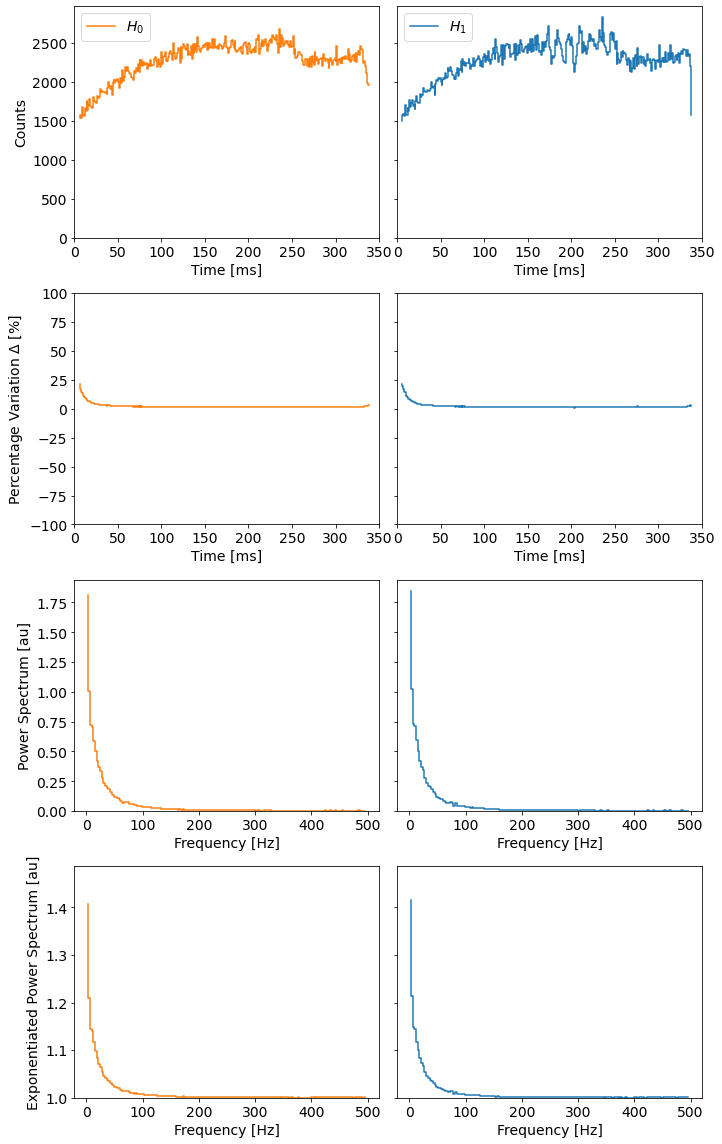

In [10]:
time_wind = [0, 500] * u.ms # time independent
freq_wind = [0, 1E6] * u.Hz # freq independent

dt = 1*u.ms
d = 10
t, f, r, pd, p, bj  = signal_processing(sim, dt=dt, distance=d*u.kpc, trials=10, residual=True, smoothing=False, return_pfbj=True)

S_gen2, S_ic86, B_gen2, B_ic86 = r
Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86 = pd
Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = p
Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86 = bj
        
fig, ax = plt.subplots(4,2, figsize = (10,16), sharey='row')

ax = ax.ravel()

ax[0].step(t, B_ic86[0], color = 'C1', ls = '-', label=r'$H_{0}$', zorder = -10)
ax[0].set_xlabel('Time [ms]', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_xlim(0,350)
ax[0].set_ylim(0,1.05*np.max(S_ic86[0]))
ax[0].tick_params(labelsize = 14)
ax[0].legend(ncols = 2, fontsize = 14, loc = 'upper left')
ax[1].step(t, S_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = -10)
ax[1].set_xlabel('Time [ms]', fontsize = 14)
ax[1].set_xlim(0,350)
ax[1].tick_params(labelsize = 14)
ax[1].legend(ncols = 2, fontsize = 14, loc = 'upper left')

ax[2].step(t, Bpd_ic86[0], color = 'C1', ls = '-', label=r'$H_{0}$', zorder = -10)
ax[2].set_xlabel('Time [ms]', fontsize = 14)
ax[2].set_ylabel('Percentage Variation $\Delta$ [%]', fontsize = 14)
ax[2].set_xlim(0,350)
ax[2].set_ylim(-100,100)
ax[2].tick_params(labelsize = 14)
ax[3].step(t, Spd_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = -10)
ax[3].set_xlabel('Time [ms]', fontsize = 14)
ax[3].set_xlim(0,350)
ax[3].tick_params(labelsize = 14)

ax[4].step(f, Bp_ic86[0], color = 'C1',  ls = '-', label=r'$H_{0}$', zorder = 10)
ax[4].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[4].set_ylabel('Power Spectrum [au]', fontsize = 14)
ax[4].set_ylim(0,1.05*np.max(Sp_ic86[0]))
ax[4].tick_params(labelsize = 14)
ax[5].step(f, Sp_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = 10)
ax[5].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[5].tick_params(labelsize = 14)

ax[6].step(f, Bbj_ic86[0], color = 'C1',  ls = '-', label=r'$H_{0}$', zorder = 10)
ax[6].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[6].set_ylabel('Exponentiated Power Spectrum [au]', fontsize = 14)
ax[6].set_ylim(1,1.05*np.max(Sbj_ic86[0]))
ax[6].tick_params(labelsize = 14)
ax[7].step(f, Sbj_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = 10)
ax[7].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[7].tick_params(labelsize = 14)

plt.title('')

#plt.savefig("../plots/ftf_bj_d={}kpc_reds.pdf".format(d), dpi = 200)
plt.tight_layout()

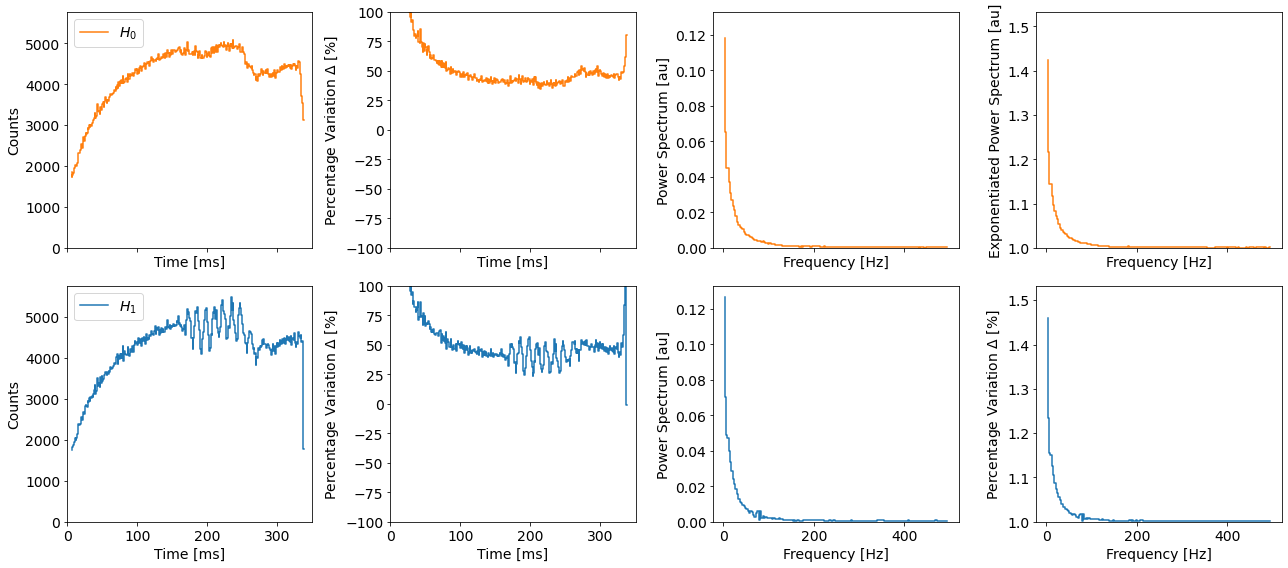

In [11]:
time_wind = [0, 500] * u.ms # time independent
freq_wind = [0, 1E6] * u.Hz # freq independent

dt = 1*u.ms
d = 5
t, f, r, pd, p, bj  = signal_processing(sim, dt=1*u.ms, distance=d*u.kpc, trials=10, residual=True, smoothing=False, return_pfbj=True)

S_gen2, S_ic86, B_gen2, B_ic86 = r
Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86 = pd
Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = p
Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86 = bj

fig, ax = plt.subplots(2,4, figsize = (18,8), sharex='col')

ax = ax.ravel()

ax[0].step(t, B_ic86[0], color = 'C1', ls = '-', label=r'$H_{0}$', zorder = -10)
ax[0].set_xlabel('Time [ms]', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_xlim(0,350)
ax[0].set_ylim(0,1.05*np.max(S_ic86[0]))
ax[0].tick_params(labelsize = 14)
ax[0].legend(ncols = 2, fontsize = 14, loc = 'upper left')

ax[1].step(t, Bpd_ic86[0]*100, color = 'C1', ls = '-', label=r'$H_{0}$', zorder = -10)
ax[1].set_xlabel('Time [ms]', fontsize = 14)
ax[1].set_ylabel('Percentage Variation $\Delta$ [%]', fontsize = 14)
ax[1].set_xlim(0,350)
ax[1].set_ylim(-100,100)
ax[1].tick_params(labelsize = 14)

ax[2].step(f, Bp_ic86[0], color = 'C1',  ls = '-', label=r'$H_{0}$', zorder = 10)
ax[2].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[2].set_ylabel('Power Spectrum [au]', fontsize = 14)
ax[2].set_ylim(0,1.05*np.max(Sp_ic86[0]))
ax[2].tick_params(labelsize = 14)

ax[3].step(f, Bbj_ic86[0], color = 'C1',  ls = '-', label=r'$H_{0}$', zorder = 10)
ax[3].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[3].set_ylabel('Exponentiated Power Spectrum [au]', fontsize = 14)
ax[3].set_ylim(1,1.05*np.max(Sbj_ic86[0]))
ax[3].tick_params(labelsize = 14)

ax[4].step(t, S_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = -10)
ax[4].set_xlabel('Time [ms]', fontsize = 14)
ax[4].set_ylabel('Counts', fontsize = 14)
ax[4].set_xlim(0,350)
ax[4].set_ylim(0,1.05*np.max(S_ic86[0]))
ax[4].tick_params(labelsize = 14)
ax[4].legend(ncols = 2, fontsize = 14, loc = 'upper left')

ax[5].step(t, Spd_ic86[0]*100, color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = -10)
ax[5].set_xlabel('Time [ms]', fontsize = 14)
ax[5].set_ylabel('Percentage Variation $\Delta$ [%]', fontsize = 14)
ax[5].set_xlim(0,350)
ax[5].set_ylim(-100,100)
ax[5].tick_params(labelsize = 14)

ax[6].step(f, Sp_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = 10)
ax[6].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[6].set_ylabel('Power Spectrum [au]', fontsize = 14)
ax[6].tick_params(labelsize = 14)
ax[6].set_ylim(0,1.05*np.max(Sp_ic86[0]))

ax[7].step(f, Sbj_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = 10)
ax[7].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[7].set_ylabel('Percentage Variation $\Delta$ [%]', fontsize = 14)
ax[7].tick_params(labelsize = 14)
ax[7].set_ylim(1,1.05*np.max(Sbj_ic86[0]))

plt.title('')

#plt.savefig("../plots/ftf_bj_d={}kpc_reds.pdf".format(d), dpi = 200)
plt.tight_layout()

In [12]:
dt

<Quantity 1. ms>

In [13]:
time_wind = [0, 500] * u.ms # time independent
freq_wind = [50, 1E6] * u.Hz # freq independent

d = 20
t, f, ff, r, pd, p, bj  = signal_processing(sim, dt=dt, distance=d*u.kpc, trials=10, residual=False, smoothing=False, return_pfbj=True)

S_gen2, S_ic86, B_gen2, B_ic86 = r
Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86 = pd
Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = p
Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86 = bj
        
fig, ax = plt.subplots(3,2, figsize = (10,12), sharey='row', sharex='row')
ax = ax.ravel()

ax[0].step(t, B_ic86[0], color = 'C1', ls = '-', label=r'$H_{0}$', zorder = -10)
ax[0].set_xlabel('Time [ms]', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_xlim(0,350)
ax[0].set_ylim(0,1.05*np.max(S_ic86[0]))
ax[0].tick_params(labelsize = 14)
ax[0].legend(ncols = 2, fontsize = 14, loc = 'upper left')
ax[1].step(t, S_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = -10)
ax[1].set_xlabel('Time [ms]', fontsize = 14)
ax[1].tick_params(labelsize = 14)
ax[1].legend(ncols = 2, fontsize = 14, loc = 'upper left')

ax[2].step(f, Bp_ic86[0], color = 'C1',  ls = '-', label=r'$H_{0}$', zorder = 10)
ax[2].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[2].set_ylabel('Power Spectrum [au]', fontsize = 14)
ax[2].set_xlim(-5,500)
ax[2].set_ylim(0,1.2*np.max(Sp_ic86[0][f>75]))
ax[2].tick_params(labelsize = 14)
ax[3].step(f, Sp_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = 10)
ax[3].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[3].tick_params(labelsize = 14)

ax[4].step(ff, Bbj_ic86[0], color = 'C1',  ls = '-', label=r'$H_{0}$', zorder = 10)
ax[4].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[4].set_ylabel('Exponentiated Power Spectrum [au]', fontsize = 14)
ax[4].set_xlim(-5,500)
ax[4].tick_params(labelsize = 14)
ax[5].step(ff, Sbj_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = 10)
ax[5].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[5].tick_params(labelsize = 14)

plt.title('')

plt.savefig("../plots/ftf_bj_d={}kpc_noreds.pdf".format(d), dpi = 200)
plt.tight_layout()

ValueError: not enough values to unpack (expected 7, got 6)

(0.0, 75.0)

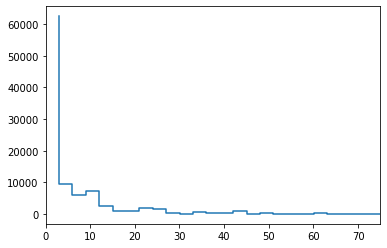

In [55]:
plt.step(f, Bp_ic86[0])
plt.xlim(0,75)
#plt.yscale('log')

In [ ]:
f, Sm_gen2, Sm_ic86_10, Bm_gen2, Bm_ic86_10, Bf_gen2, Bf_ic86_10 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=100000, return_max_power=True)
f, Sm_gen2, Sm_ic86_20, Bm_gen2, Bm_ic86_20, Bf_gen2, Bf_ic86_20 = signal_processing(sim, dt=dt, distance=20*u.kpc, trials=100000, return_max_power=True)

In [ ]:
pp_10 = np.linspace(100, 4000, 1000)
pp_20 = np.linspace(100, 900, 1000)

qs_10 = np.array([np.quantile(Sm_ic86_10, 0.14), np.quantile(Sm_ic86_10, 0.86)])
qs_20 = np.array([np.quantile(Sm_ic86_20, 0.14), np.quantile(Sm_ic86_20, 0.86)])
qb_10 = np.array([np.quantile(Bm_ic86_10, 0.14), np.quantile(Bm_ic86_10, 0.86)])
qb_20 = np.array([np.quantile(Bm_ic86_20, 0.14), np.quantile(Bm_ic86_20, 0.86)])


y_bm_ic86_10, bins_bm_ic86_10 = np.histogram(Bm_ic86_10, bins = 50, density = True)
y_sm_ic86_10, bins_sm_ic86_10 = np.histogram(Sm_ic86_10, bins = 50, density = True)
y_bm_ic86_20, bins_bm_ic86_20 = np.histogram(Bm_ic86_20, bins = 50, density = True)
y_sm_ic86_20, bins_sm_ic86_20 = np.histogram(Sm_ic86_20, bins = 50, density = True)

x_bm_ic86_10 = (bins_bm_ic86_10[:-1]+bins_bm_ic86_10[1:])/2
x_sm_ic86_10 = (bins_sm_ic86_10[:-1]+bins_sm_ic86_10[1:])/2
x_bm_ic86_20 = (bins_bm_ic86_20[:-1]+bins_bm_ic86_20[1:])/2
x_sm_ic86_20 = (bins_sm_ic86_20[:-1]+bins_sm_ic86_20[1:])/2


m_sm_ic86_10 = np.logical_and(x_sm_ic86_10 > qs_10[0], x_sm_ic86_10 < qs_10[1])
m_bm_ic86_10 = np.logical_and(x_bm_ic86_10 > qb_10[0], x_bm_ic86_10 < qb_10[1])
m_sm_ic86_20 = np.logical_and(x_sm_ic86_20 > qs_20[0], x_sm_ic86_20 < qs_20[1])
m_bm_ic86_20 = np.logical_and(x_bm_ic86_20 > qb_20[0], x_bm_ic86_20 < qb_20[1])



fig, ax = plt.subplots(2,1, figsize = (10,5)) 

ax[0].step(x_bm_ic86_10, y_bm_ic86_10, color = 'C1', ls = '-', lw = 2, label=r'$H_0$', where = 'mid')
ax[0].step(x_sm_ic86_10, y_sm_ic86_10, color = 'C0', ls = '-', lw = 2, label=r'$H_1$', where = 'mid')
#ax[0].plot(pp_10, Bf_ic86_10.pdf(pp_10), color = 'k', ls = '--')

#ax[0].axvline(np.median(Bm_ic86_10), ymin = 0, ymax =np.max(y_bm_ic86_10)/0.011, color = 'C1', ls = '-')
#ax[0].axvline(np.median(Sm_ic86_10), ymin = 0, ymax =np.max(y_sm_ic86_10)/0.01, color = 'C0', ls = '-')
ax[0].fill_between(x = x_bm_ic86_10[m_bm_ic86_10], y1 = y_bm_ic86_10[m_bm_ic86_10], color = 'C1', alpha = 0.5)
ax[0].fill_between(x = x_sm_ic86_10[m_sm_ic86_10], y1 = y_sm_ic86_10[m_sm_ic86_10], color = 'C0', alpha = 0.5)
#ax[0].text(700, 0.0085, r"10 kpc", size=14,
#         ha="center", va="center",
#         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)


ax[1].step(x_bm_ic86_20, y_bm_ic86_20, color = 'C1', ls = '-', lw = 2, label=r'$H_0$', where = 'mid')
ax[1].step(x_sm_ic86_20, y_sm_ic86_20, color = 'C0', ls = '-', lw = 2, label=r'$H_1$', where = 'mid')
#ax[1].plot(pp_20, Bf_ic86_20.pdf(pp_20), color = 'k', ls = '--')

#ax[1].axvline(np.median(Bm_ic86_20), ymin = 0, ymax =np.max(y_bm_ic86_20)/0.01, color = 'C1', ls = '-')
#ax[1].axvline(np.median(Sm_ic86_20), ymin = 0, ymax =np.max(y_sm_ic86_20)/0.01, color = 'C0', ls = '-')
ax[1].fill_between(x = x_bm_ic86_20[m_bm_ic86_20], y1 = y_bm_ic86_20[m_bm_ic86_20], color = 'C1', alpha = 0.5)
ax[1].fill_between(x = x_sm_ic86_20[m_sm_ic86_20], y1 = y_sm_ic86_20[m_sm_ic86_20], color = 'C0', alpha = 0.5)
#ax[1].text(700, 0.0085, r"20 kpc", size=14,
#         ha="center", va="center",
#         bbox=dict(boxstyle="square", ec='k', fc='white', alpha = 1), zorder = 30)


for i in range(2):
    ax[i].set_xlabel('Test Statistic [au]', fontsize = 14)
    ax[i].set_ylabel('Normalized Counts', fontsize = 14)
    ax[i].tick_params(labelsize = 14)
    #ax[i].set_xscale('log')
    #ax[i].set_xlim(1E2,5E3)
    #ax[i].set_ylim(0,1E-2)
    #ax[i].set_xticks([100, 200, 500, 1E3, 2E3, 5E3])
    #ax[i].set_yticks([0, 5E-3, 1E-2])
    ax[i].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax[i].legend(ncols = 2, fontsize = 14, loc = 'upper right')
plt.tight_layout()
#plt.savefig("../plots/ftf_bj_tsdist_noresiduals.pdf", dpi = 200)